In [1]:
from enum import Enum

class ClassDataType(Enum):
    COVID19 = 'COVID19'
    NORMAL = 'NORMAL'
    PNEUMONIA = 'PNEUMONIA'

In [2]:
import torch
from PIL import Image
from torchvision.transforms import v2


def load_img(path):
    img = Image.open(path).convert('RGB')
    img = v2.functional.to_image(img)
    img = v2.functional.to_dtype(img, dtype=torch.uint8, scale=True)
    return img

In [3]:
from typing import Callable

import kagglehub
import torch
import os

from torch import Tensor


class Config:
    NUM_EPOCHS = 50
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-3
    PATIENCE = 5

    IMG_SIZE = 224
    TRAIN_SPLIT_RATIO = 0.8

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    NUM_WORKERS = os.cpu_count() // 2 if os.cpu_count() else 4

    MODEL_SAVE_DIR = "models"
    REPORTS_DIR = "reports"
    TENSORBOARD_DIR = "runs"

    def __init__(self, download_path: str, batch_size: int = BATCH_SIZE, learning_rate: float = LEARNING_RATE):
        os.environ['KAGGLEHUB_CACHE'] = download_path
        dataset_dir = kagglehub.dataset_download("alsaniipe/chest-x-ray-image")

        self.processed_data_dir = f"{download_path}/processed"
        self.base_dir = f"{dataset_dir}/Data"

        self.train_dir = os.path.join(self.base_dir, 'train')
        self.test_dir = os.path.join(self.base_dir, 'test')
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def qtd_images_train(self) -> tuple[int, int, int]:
        return self.qtd_images_dir(self.train_dir)

    def qtd_images_test(self) -> tuple[int, int, int]:
        return self.qtd_images_dir(self.test_dir)

    def class_weights_train(self) -> Tensor:
        return self.class_weights(self.qtd_images_train)

    def class_weights_test(self) -> Tensor:
        return self.class_weights(self.qtd_images_test)

    def class_weights(self, func: Callable[[], tuple[int, int, int]]) -> Tensor:
        qtd_num_covid, qtd_num_normal, qtd_num_pneumonia = func()
        print(f"Covid: {qtd_num_covid}, Normal: {qtd_num_normal}, Pneumonia: {qtd_num_pneumonia}")

        weight_covid = 1.0 / qtd_num_covid
        weight_normal = 1.0 / qtd_num_normal
        weight_pneumonia = 1.0 / qtd_num_pneumonia

        total_weight = weight_covid + weight_normal + weight_pneumonia

        return torch.tensor([
            weight_covid / total_weight,
            weight_normal / total_weight,
            weight_pneumonia / total_weight
        ]).to(self.DEVICE)

    @staticmethod
    def qtd_images_dir(dataset_dir: str) -> tuple[int, int, int]:
        covid_path = os.path.join(dataset_dir, 'COVID19')
        normal_path = os.path.join(dataset_dir, 'NORMAL')
        pneumonia_path = os.path.join(dataset_dir, 'PNEUMONIA')

        qtd_num_covid = len(os.listdir(covid_path))
        qtd_num_normal = len(os.listdir(normal_path))
        qtd_num_pneumonia = len(os.listdir(pneumonia_path))

        return qtd_num_covid, qtd_num_normal, qtd_num_pneumonia

/home/hygo2025/miniconda3/envs/conda_recs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from torchvision.transforms import v2
from tqdm import tqdm


class Preprocessor:
    def __init__(self, config: Config):
        self.config = config
        self.img_size = config.IMG_SIZE
        self.source_base_dir = config.base_dir
        self.target_base_dir = config.processed_data_dir

    def run(self, padding: int = 32):

        resize_transform = v2.Resize((self.img_size + padding, self.img_size + padding))

        print(f"Iniciando pré-processamento de '{self.config.base_dir}' para '{self.config.processed_data_dir}'...")

        for split in ['train', 'val', 'test']:
            source_dir = os.path.join(self.source_base_dir, split)
            target_dir = os.path.join(self.target_base_dir, split)

            if not os.path.isdir(source_dir):
                continue

            all_paths = [
                os.path.join(dirpath, filename)
                for dirpath, _, filenames in os.walk(source_dir)
                for filename in filenames
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
            ]

            if not all_paths:
                continue

            for img_path in tqdm(all_paths, desc=f"running {split}"):
                relative_path = os.path.relpath(img_path, source_dir)
                target_img_path = os.path.join(target_dir, os.path.splitext(relative_path)[0] + '.png')

                if os.path.exists(target_img_path):
                    continue

                try:
                    os.makedirs(os.path.dirname(target_img_path), exist_ok=True)

                    img_tensor = load_img(img_path)
                    img_resized = resize_transform(img_tensor)

                    pil_img = v2.functional.to_pil_image(img_resized)
                    pil_img.save(target_img_path)

                except Exception as e:
                    print(f"Erro ao processar a imagem {img_path}: {e}")

        print("\nPré-processamento concluído!")

In [5]:
from torch import nn
import numpy as np
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class ReportData:
    def __init__(self, config: Config):
        self.train_dir = config.train_dir
        self.test_dir = config.test_dir

    def print_data_organized(self) -> None:
        for dataset_type, dataset_dir in [('Treino', self.train_dir), ('Teste', self.test_dir)]:
            covid_path = os.path.join(dataset_dir, 'COVID19')
            normal_path = os.path.join(dataset_dir, 'NORMAL')
            pneumonia_path = os.path.join(dataset_dir, 'PNEUMONIA')

            qtd_num_covid = len(os.listdir(covid_path))
            qtd_num_normal = len(os.listdir(normal_path))
            qtd_num_pneumonia = len(os.listdir(pneumonia_path))

            print(f"Conjunto de {dataset_type}:")
            print(f"  - Imagens com Covid: {qtd_num_covid}")
            print(f"  - Imagens Normais: {qtd_num_normal}")
            print(f"  - Imagens com Pneumonia: {qtd_num_pneumonia}")
            print(f"  - Total: {qtd_num_covid + qtd_num_normal + qtd_num_pneumonia}\n")

    def plot_samples(self, category_type: ClassDataType, num_samples=5):
        image_path = os.path.join(self.train_dir, category_type.value)
        plt.figure(figsize=(12, 4))
        image_files = os.listdir(image_path)[:num_samples]

        for i, file_name in enumerate(image_files):
            img = Image.open(os.path.join(image_path, file_name))
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"{category_type.value} {i + 1}")
            plt.axis('off')
        plt.show()

    @staticmethod
    def print_grid(class_names: [str], data_loader: DataLoader) -> None:
        def imshow(grid_imgs, title=""):
            grid_imgs = grid_imgs.numpy().transpose((1, 2, 0))
            plt.imshow(grid_imgs, cmap='gray')
            plt.title(title, fontsize=12)
            plt.axis('off')

        imgs, labels = next(iter(data_loader))

        plt.figure(figsize=(24,12))
        imshow(
            grid_imgs=torchvision.utils.make_grid(imgs),
            title=f"Amostras: {[class_names[x] for x in labels][:5]}..."
        )
        plt.show()

    @staticmethod
    def print_normalized_images(class_names: [str], data_loader: DataLoader):
        imgs, labels = next(iter(data_loader))

        def imshow_normalized(grid_imgs, title=""):
            grid_imgs = grid_imgs.numpy().transpose((1, 2, 0))
            mean = np.array([0.5])
            std = np.array([0.5])
            grid_imgs = std * grid_imgs + mean
            grid_imgs = np.clip(grid_imgs, 0, 1) # Garante que os valores fiquem entre 0 e 1
            plt.imshow(grid_imgs, cmap='gray')
            plt.title(title, fontsize=10)
            plt.axis('off')

        num_images_to_show = 32
        images_to_show = imgs[:num_images_to_show]
        labels_to_show = labels[:num_images_to_show]

        plt.figure(figsize=(24,12))
        imshow_normalized(
            grid_imgs=torchvision.utils.make_grid(images_to_show, nrow=8),
            title=f"Amostras: {[class_names[x] for x in labels_to_show[:8]]}..."
        )
        plt.show()


    @staticmethod
    def print_history_data(history: list) -> None:
        history = np.array(history)

        plt.figure(figsize=(16, 6))

        plt.subplot(1, 2, 1)
        plt.title('Acurácia ao Longo das Épocas')
        plt.plot(history[:, 1], '-o', label='Acurácia de Treino')
        plt.plot(history[:, 3], '-o', label='Acurácia de Validação')
        plt.xlabel('Época')
        plt.ylabel('Acurácia')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.title('Loss ao Longo das Épocas')
        plt.plot(history[:, 0], '-o', label='Perda de Treino')
        plt.plot(history[:, 2], '-o', label='Perda de Validação')
        plt.xlabel('Época')
        plt.ylabel('Perda')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def compare_results(class_names: [str], data_loader: DataLoader, model: nn.Module, device: str) -> None:

        def show_batch(images, labels, class_names, net=None):
            prd = None
            if net:
                with torch.no_grad():
                    images_gpu = images.to(device)
                    prd = net(images_gpu).cpu().numpy()
                prd = np.argmax(prd, axis=-1)

            n = len(images)
            grid_size = int(np.ceil(np.sqrt(n)))
            plt.figure(figsize=(12, 12))

            for idx in range(n):
                plt.subplot(grid_size, grid_size, idx + 1)
                img = images[idx].numpy()
                img = np.transpose(img, (1, 2, 0))

                mean = np.array([0.5, 0.5, 0.5])
                std = np.array([0.5, 0.5, 0.5])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                plt.imshow(img)
                plt.grid(False)
                plt.axis('off')

                title = f'True: {class_names[labels[idx]]}'
                if prd is not None:
                    title += f'\nPred: {class_names[prd[idx]]}'
                plt.title(title)

            plt.tight_layout()
            plt.show()

        model.eval()
        images, labels = next(iter(data_loader))

        show_batch(images, labels, class_names, model)


    @staticmethod
    def confusion_matrix(class_names: [str]):
        cm = confusion_matrix(true, pred, labels=list(range(len(class_names))))

        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=class_names)

        disp.plot(cmap='cividis', xticks_rotation='vertical')
        plt.grid(False)
        plt.title('Matriz de Confusão')
        plt.show()


In [6]:
import torch
import torchvision.datasets as datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split


class DataHandler:
    def __init__(self, config: Config):
        self.config = config
        self._create_transforms()
        self._setup_datasets()
        self._create_dataloaders()

    def _create_transforms(self):
        self.train_transform = v2.Compose([
            v2.Resize(size=(self.config.IMG_SIZE, self.config.IMG_SIZE)),

            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(10),
            v2.ColorJitter(brightness=0.2, contrast=0.2),

            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        self.val_test_transform = v2.Compose([
            v2.Resize(size=(self.config.IMG_SIZE, self.config.IMG_SIZE)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

        self.original_transform = v2.Compose([
            v2.Resize((self.config.IMG_SIZE, self.config.IMG_SIZE)),
            v2.ToTensor()
        ])

    def _setup_datasets(self):
        self.train_dataset_original = datasets.ImageFolder(self.config.train_dir, transform=self.original_transform)
        self.test_dataset_original = datasets.ImageFolder(self.config.test_dir, transform=self.original_transform)

        self.full_train_dataset = datasets.ImageFolder(
            self.config.train_dir,
            transform=self.train_transform
        )

        self.test_dataset = datasets.ImageFolder(
            self.config.test_dir,
            transform=self.val_test_transform
        )

        train_size = int(self.config.TRAIN_SPLIT_RATIO * len(self.full_train_dataset))

        test_size = len(self.full_train_dataset) - train_size

        self.train_subset, self.val_subset = random_split(self.full_train_dataset, [train_size, test_size])

        self.class_names = self.full_train_dataset.classes
        print(f"Datasets criados. Classes: {self.class_names}")
        print(
            f"Tamanho do treino: {len(self.train_subset)}, Validacao: {len(self.val_subset)}, Teste: {len(self.test_dataset)}")

    def _create_dataloaders(self):
        self.train_loader_original = torch.utils.data.DataLoader(self.train_dataset_original, batch_size=self.config.batch_size, shuffle=True)
        self.test_loader_original = torch.utils.data.DataLoader(self.test_dataset_original, batch_size=self.config.batch_size, shuffle=False)

        self.train_loader = DataLoader(
            self.train_subset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=self.config.NUM_WORKERS, pin_memory=True)
        self.val_loader = DataLoader(
            self.val_subset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.NUM_WORKERS,
            pin_memory=True
        )
        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.NUM_WORKERS,
            pin_memory=True
        )
        print("DataLoaders criados com sucesso.")

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.printed = False
        # o kernel é aquela parte que vai se movimentando na imagem igual o professor explicou
        # o padding de 1 é para a imagem nao diminuir visto que o kernel de 3 poderia dar bo
        # in_channels de 3 foi pq na funcao que o professor colocou ele transforma para rgb
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=64 * 28 * 28, out_features=512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        if not self.printed:
            self.printed = True
            print("Shape do tensor antes do flatten:", x.shape)
            print("[batch_size, canais, altura, largura] - multiplicar tudo, exceto o batch_size")

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def embedding(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        return x


In [8]:
from torch.nn.modules.loss import CrossEntropyLoss
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
import os


class Trainer:
    def __init__(self,
                 model: nn.Module,
                 dataloaders: dict,
                 loss_fn: CrossEntropyLoss,
                 optimizer: torch.optim.Optimizer,
                 config: Config,
                 experiment_name: str,
                 writer: SummaryWriter):
        self._model = model
        self._train_loader = dataloaders['train']
        self._val_loader = dataloaders['val']
        self._loss_fn = loss_fn
        self._optimizer = optimizer
        self._config = config
        self._device = config.DEVICE

        self.history = []
        self._best_val_acc = 0.0
        self._early_stop_counter = 0
        self.model_save_path = os.path.join(config.MODEL_SAVE_DIR, f"{experiment_name}.pth")
        os.makedirs(os.path.dirname(self.model_save_path), exist_ok=True)

        self._writer = writer

    def _train_step(self):

        self._model.train()

        running_loss = 0.0
        all_preds = []
        all_labels = []

        for data in self._train_loader:
            inputs, labels = data

            all_labels.extend(labels.cpu().numpy())

            inputs = inputs.to(self._device)
            labels = labels.to(self._device)

            self._optimizer.zero_grad()

            outputs = self._model(inputs)
            loss = self._loss_fn(outputs, labels)
            loss.backward()
            self._optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())

            running_loss += loss.item()

        avg_train_loss = running_loss / len(self._train_loader)

        return all_labels, all_preds, avg_train_loss

    def _eval_step(self):
        return self.eval_step(
            model_eval=self._model,
            device_eval=self._device,
            loss_fn_eval=self._loss_fn,
            dataloader=self._val_loader
        )

    @staticmethod
    def eval_step(model_eval: nn.Module, device_eval: str, loss_fn_eval: CrossEntropyLoss, dataloader: DataLoader):
        model_eval.eval()
        eval_loss = 0.0
        all_preds = []
        all_labels = []
        _val_loader = dataloader


        with torch.no_grad():
            for data in _val_loader:
                images, labels = data
                all_labels.extend(labels.cpu().numpy())

                images = images.to(device_eval)
                labels = labels.to(device_eval)

                outputs = model_eval(images)

                loss = loss_fn_eval(outputs, labels)
                eval_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())

        avg_eval_loss = eval_loss / len(_val_loader)

        return all_labels, all_preds, avg_eval_loss

    def train(self):
        for epoch in range(self._config.NUM_EPOCHS):
            true_train, pred_train, train_loss = self._train_step()
            train_acc = accuracy_score(true_train, pred_train)

            val, pred_val, val_loss = self._eval_step()
            val_acc = accuracy_score(val, pred_val)

            self.history.append([train_loss, train_acc, val_loss, val_acc])
            print(
                f"Epoch {epoch + 1} | train loss: {train_loss:.4f} | train acc: {train_acc:.4f} | val loss: {val_loss:.4f} | val acc: {val_acc:.4f}")

            if val_acc > self._best_val_acc:
                self._best_val_acc = val_acc
                torch.save(self._model.state_dict(), self.model_save_path)
                self._early_stop_counter = 0
            else:
                self._early_stop_counter += 1

            if self._early_stop_counter >= self._config.PATIENCE:
                print(f"\nEarly stopping ativado na época {epoch + 1}.")
                break

            self._writer.add_scalars("loss", {"train": train_loss, "val": val_loss}, epoch)
            self._writer.add_scalars("accuracy", {"train": train_acc, "val": val_acc}, epoch)

        self._writer.close()


In [19]:
class Setup:
    def __init__(self,
                 config: Config = None,
                 base_dataset_path: str = f"/home/{os.environ['USER']}/Documents/datasets",
                 ):
        self.base_dataset_path = base_dataset_path
        if config is None:
            self.config_instance = Config(download_path=self.base_dataset_path)
        else:
            self.config_instance = config
        self.preprocessor = Preprocessor(config=self.config_instance)
        self.report_data = ReportData(config=self.config_instance)
        self.data_handler = DataHandler(self.config_instance)
        self.dataloaders = {
            "train": self.data_handler.train_loader,
            "val": self.data_handler.val_loader,
            "test": self.data_handler.test_loader
        }
        self.num_classes = len(self.data_handler.class_names)


## Setup

In [44]:
import os

base_dataset_path = f"/home/{os.environ['USER']}/Documents/datasets"
config_instance = Config(download_path=base_dataset_path)
Preprocessor(config=config_instance).run()

Iniciando pré-processamento de '/home/hygo2025/Documents/datasets/datasets/alsaniipe/chest-x-ray-image/versions/1/Data' para '/home/hygo2025/Documents/datasets/processed'...


running test: 100%|██████████| 1288/1288 [00:00<00:00, 103281.91it/s]


Pré-processamento concluído!


In [45]:
report_data = ReportData(config=config_instance)
report_data.print_data_organized()

Conjunto de Treino:
  - Imagens com Covid: 460
  - Imagens Normais: 1266
  - Imagens com Pneumonia: 3418
  - Total: 5144

Conjunto de Teste:
  - Imagens com Covid: 116
  - Imagens Normais: 317
  - Imagens com Pneumonia: 855
  - Total: 1288



#### Imagens normais

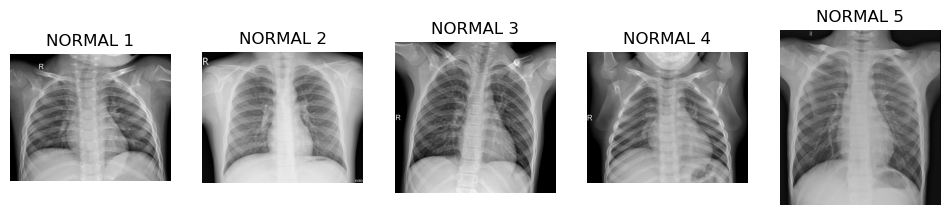

In [46]:
report_data.plot_samples(category_type=ClassDataType.NORMAL)

#### Imagens com covid

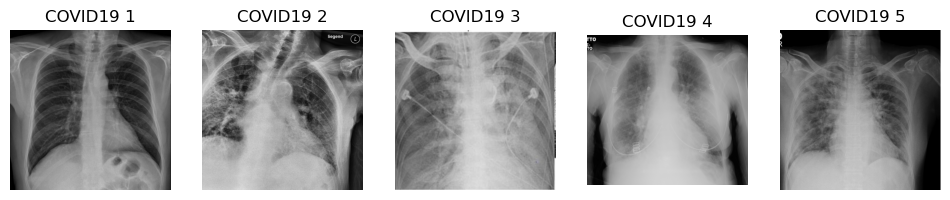

In [47]:
report_data.plot_samples(category_type=ClassDataType.COVID19)

#### Imagens pneumonia

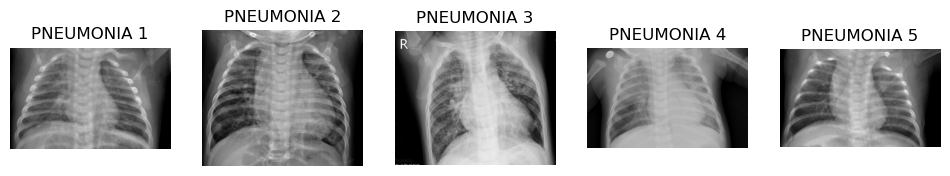

In [48]:
report_data.plot_samples(category_type=ClassDataType.PNEUMONIA)

In [49]:
#### Criando os dataloaders

In [50]:
data_handler = DataHandler(config_instance)
dataloaders = {
    "train": data_handler.train_loader,
    "val": data_handler.val_loader,
    "test": data_handler.test_loader
}
num_classes = len(data_handler.class_names)

Datasets criados. Classes: ['COVID19', 'NORMAL', 'PNEUMONIA']
Tamanho do treino: 4115, Validacao: 1029, Teste: 1288
DataLoaders criados com sucesso.


/home/hygo2025/miniconda3/envs/conda_recs/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [51]:
#### Verificando se os dados continuam com a mesma cara.

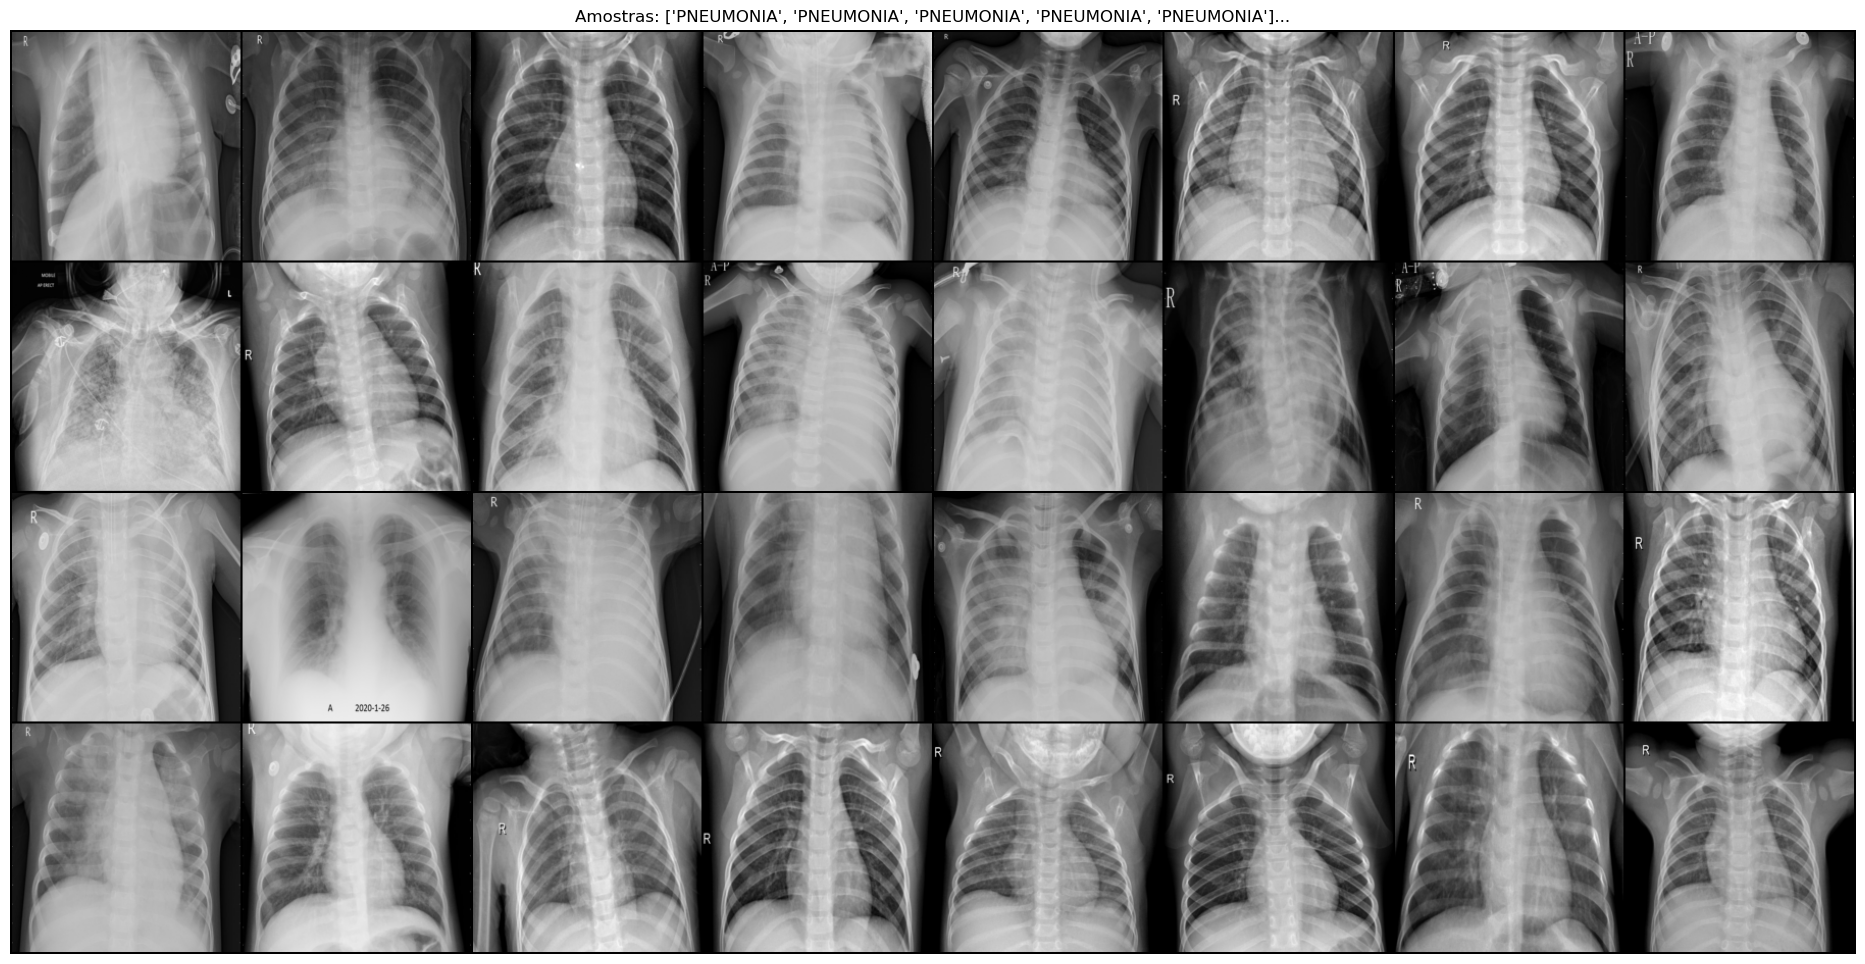

In [52]:
ReportData.print_grid(class_names=data_handler.test_dataset_original.classes, data_loader=data_handler.train_loader_original)

### Checando disponibilidade de cuda

In [53]:
import torch

if torch.cuda.is_available():
    print("CUDA está disponível! Treinamento usará a GPU.")
    print("Dispositivo CUDA:", torch.cuda.get_device_name(0))
    print("Versão do PyTorch:", torch.__version__)
    print("Versão do CUDA que o PyTorch foi compilado:", torch.version.cuda)
else:
    print("CUDA NÃO está disponível. Treinamento usará a CPU.")


CUDA está disponível! Treinamento usará a GPU.
Dispositivo CUDA: NVIDIA GeForce RTX 4090
Versão do PyTorch: 2.5.1
Versão do CUDA que o PyTorch foi compilado: 12.4


## Testando o quanto demora para iterar sob o conjunto de dados

Estava demorando muito para enviar os dados para a gpu, dai eu fiz o preprocessamento das imagens para deixar isso mais rapido e com o teste abaixo consigo garantir que essa parte nao vai demorar

In [54]:
import time

print("benchmark do DataLoader...")
start_time = time.time()

for batch in dataloaders['train']:
    pass

end_time = time.time()
print(f"time para percorrer todo o DataLoader: {end_time - start_time:.2f} segundos.")

benchmark do DataLoader...
time para percorrer todo o DataLoader: 12.79 segundos.


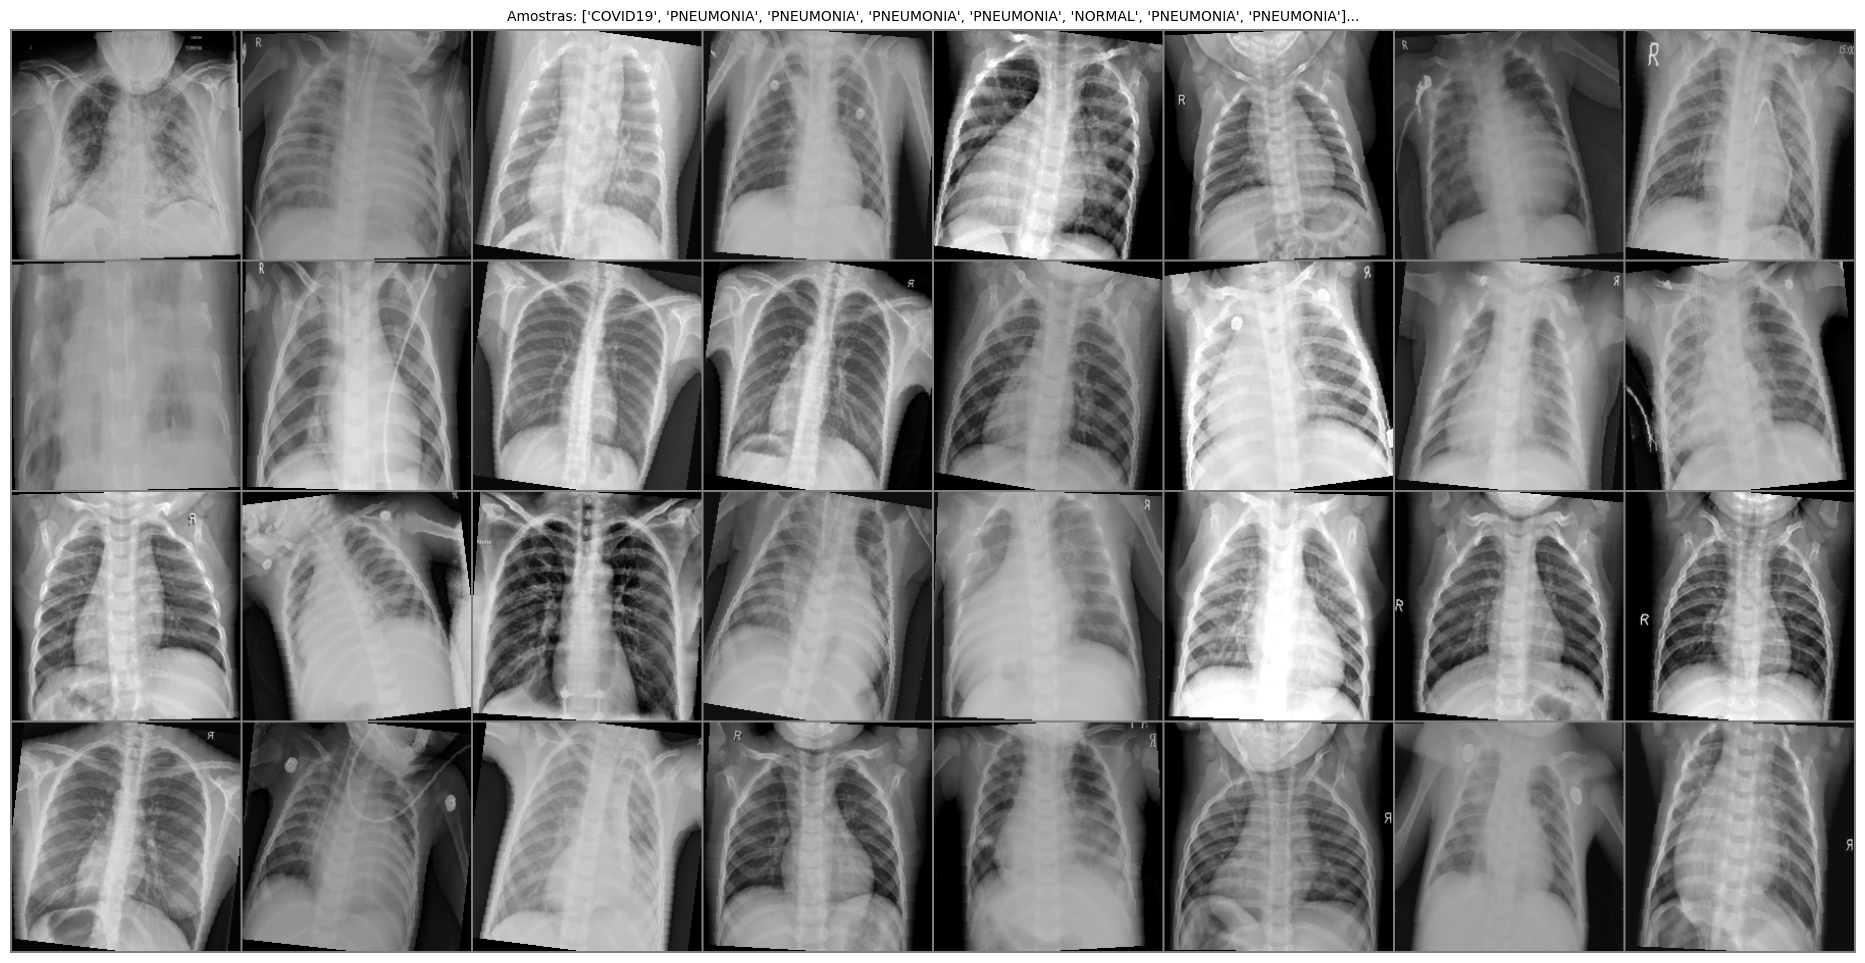

In [55]:
ReportData.print_normalized_images(class_names=data_handler.class_names, data_loader=data_handler.train_loader)

## Criando a minha rede

In [56]:
model = Net(num_classes=3)
model.to(config_instance.DEVICE)
model = torch.compile(model)

### Tesntando minha rede para um tensor dummy

In [57]:
dummy_input = torch.randn(1, 3, 224, 224).to(config_instance.DEVICE)

output = model(dummy_input)

print(f"Shape da entrada: {dummy_input.shape}")
print(f"Shape da saída: {output.shape}")
print(f"Saída (logits): {output}")

Shape do tensor antes do flatten: torch.Size([1, 64, 28, 28])
[batch_size, canais, altura, largura] - multiplicar tudo, exceto o batch_size
Shape da entrada: torch.Size([1, 3, 224, 224])
Shape da saída: torch.Size([1, 3])
Saída (logits): tensor([[-0.0878,  0.0651, -0.0426]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


## A minha base é bem desbalanceada entao vou balancear os pesos

In [58]:
class_weights = config_instance.class_weights_train()
class_weights

Covid: 460, Normal: 1266, Pneumonia: 3418


tensor([0.6676, 0.2426, 0.0898], device='cuda:0')

In [59]:
#https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import time

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(params=model.parameters(), lr=config_instance.learning_rate)

experiment_name = f"SimpleCNN_LR_001_{int(time.time())}"
writer = SummaryWriter(log_dir=f"runs/{experiment_name}")

print(f"Iniciando experimento: {experiment_name}")
print(f"Logs do TensorBoard serão salvos em: runs/{experiment_name}")

Iniciando experimento: SimpleCNN_LR_001_1753134603
Logs do TensorBoard serão salvos em: runs/SimpleCNN_LR_001_1753134603


In [60]:
trainer = Trainer(
    model=model,
    dataloaders=dataloaders,
    loss_fn=loss_fn,
    optimizer=optimizer,
    config=config_instance,
    experiment_name=experiment_name,
    writer=writer
)


In [61]:
trainer.train()

Epoch 1 | train loss: 0.5326 | train acc: 0.7650 | val loss: 0.3157 | val acc: 0.8649
Epoch 2 | train loss: 0.3387 | train acc: 0.8649 | val loss: 0.3259 | val acc: 0.8785
Epoch 3 | train loss: 0.2885 | train acc: 0.8804 | val loss: 0.3299 | val acc: 0.8970
Epoch 4 | train loss: 0.2583 | train acc: 0.8911 | val loss: 0.1971 | val acc: 0.9164
Epoch 5 | train loss: 0.2254 | train acc: 0.9030 | val loss: 0.2616 | val acc: 0.8562
Epoch 6 | train loss: 0.2131 | train acc: 0.9086 | val loss: 0.1751 | val acc: 0.9310
Epoch 7 | train loss: 0.1947 | train acc: 0.9166 | val loss: 0.1786 | val acc: 0.9155
Epoch 8 | train loss: 0.1686 | train acc: 0.9237 | val loss: 0.1936 | val acc: 0.9320
Epoch 9 | train loss: 0.1731 | train acc: 0.9295 | val loss: 0.1606 | val acc: 0.9397
Epoch 10 | train loss: 0.1740 | train acc: 0.9230 | val loss: 0.1872 | val acc: 0.9388
Epoch 11 | train loss: 0.1582 | train acc: 0.9317 | val loss: 0.1650 | val acc: 0.9359
Epoch 12 | train loss: 0.1484 | train acc: 0.9380 | 

In [62]:
model.load_state_dict(torch.load(trainer.model_save_path))

/tmp/ipykernel_218605/1285977267.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trainer.model_save_path))


<All keys matched successfully>

In [63]:
true_test, pred_test, test_loss = Trainer.eval_step(
    model_eval=model,
    device_eval=config_instance.DEVICE,
    loss_fn_eval=loss_fn,
    dataloader=dataloaders['test']
)

test_acc = accuracy_score(true_test, pred_test)
print(f"Acurácia final no teste: {test_acc:.4f} | Loss final no teste: {test_loss:.4f}")

Acurácia final no teste: 0.9379 | Loss final no teste: 0.1961


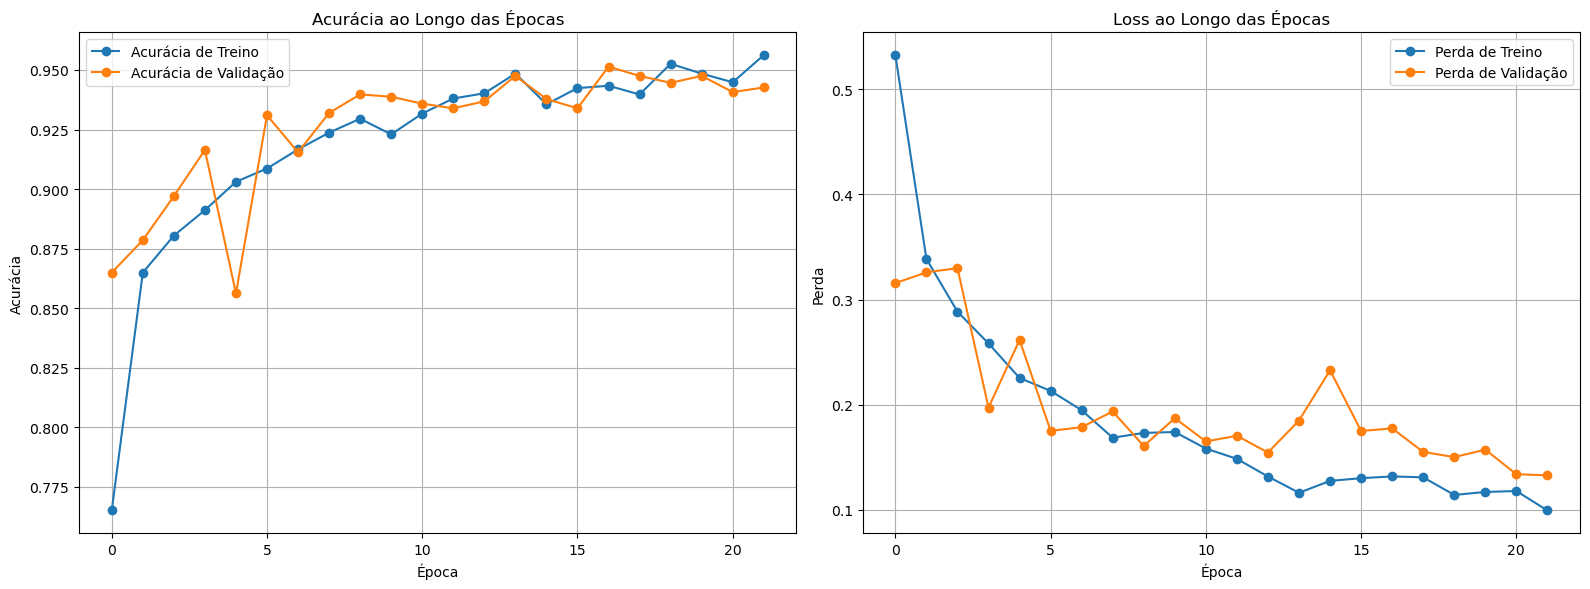

In [64]:
ReportData.print_history_data(history=trainer.history)

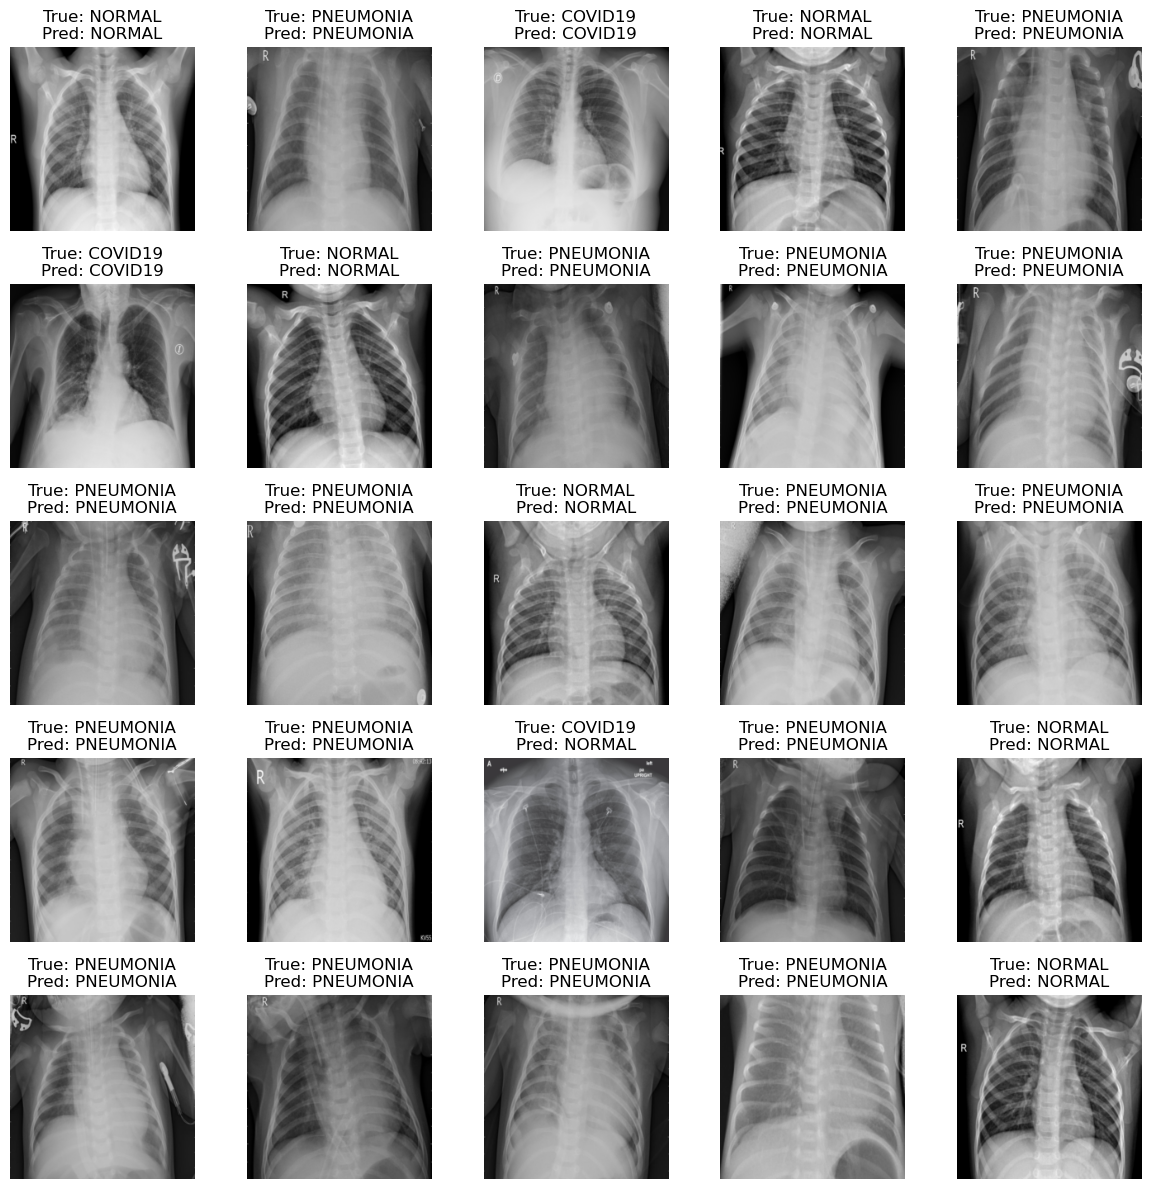

In [65]:
vis_loader = torch.utils.data.DataLoader(data_handler.test_dataset, batch_size=25, shuffle=True)

ReportData.compare_results(
    class_names=data_handler.test_dataset.classes,
    data_loader=vis_loader,
    model=model,
    device=config_instance.DEVICE,
)

In [66]:
from sklearn.metrics import classification_report

class_names = data_handler.test_dataset.classes

true, pred, loss = Trainer.eval_step(
    model_eval=model,
    device_eval=config_instance.DEVICE,
    loss_fn_eval=loss_fn,
    dataloader=dataloaders['test']
)

print("--- Relatório de Classificação Final no Conjunto de Teste ---")
print(classification_report(true, pred, target_names=data_handler.test_dataset.classes))

--- Relatório de Classificação Final no Conjunto de Teste ---
              precision    recall  f1-score   support

     COVID19       1.00      0.91      0.95       116
      NORMAL       0.84      0.93      0.88       317
   PNEUMONIA       0.97      0.95      0.96       855

    accuracy                           0.94      1288
   macro avg       0.94      0.93      0.93      1288
weighted avg       0.94      0.94      0.94      1288



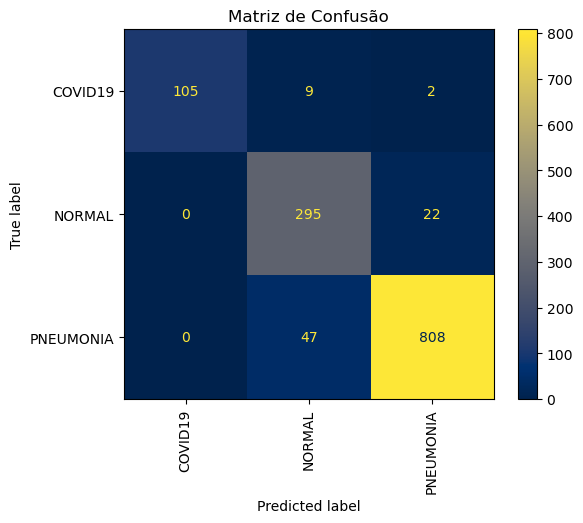

In [67]:
ReportData.confusion_matrix(class_names=data_handler.test_dataset.classes)

In [34]:
import torch
import torch.nn as nn
from torchvision import models


def get_pretrained_model(num_classes=3, feature_extract=True):
    model = models.densenet121(weights='IMAGENET1K_V1')

    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
        print("Modo: Extração de Características (Camadas Convolucionais Congeladas)")
    else:
        print("Modo: Fine-Tuning (Todas as Camadas Treináveis)")

    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)

    return model

## Rede prétreinada congelada

In [12]:
class TrainingConfig(Config):
    def __init__(self, download_path: str, batch_size: int = 32, learning_rate: float = 0.001):
        super().__init__(download_path, batch_size, learning_rate)

In [20]:
import os

base_dataset_path = f"/home/{os.environ['USER']}/Documents/datasets"

config_pre = TrainingConfig(download_path=base_dataset_path)
setup_pre = Setup(config=config_pre)


Datasets criados. Classes: ['COVID19', 'NORMAL', 'PNEUMONIA']
Tamanho do treino: 4115, Validacao: 1029, Teste: 1288
DataLoaders criados com sucesso.


In [25]:
class_names_pre = setup_pre.data_handler.test_dataset.classes

model_frozen = get_pretrained_model(num_classes=len(class_names_pre),
                                    feature_extract=True)
model_frozen.to(config_pre.DEVICE)

Modo: Extração de Características (Camadas Convolucionais Congeladas)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [28]:
#https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

class_weights_pre = config_pre.class_weights_train()

loss_fn_pre = nn.CrossEntropyLoss(weight=class_weights_pre)
params_to_update = filter(lambda p: p.requires_grad, model_frozen.parameters())
optimizer_pre = torch.optim.Adam(params_to_update, lr=config_pre.learning_rate)

experiment_name_denset_frozen = f"DenseNet_Frozen_{int(time.time())}"
writer_densenet_frozen = SummaryWriter(log_dir=f"runs/{experiment_name_denset_frozen}")

print(f"Iniciando experimento: {experiment_name_denset_frozen}")
print(f"Logs do TensorBoard serão salvos em: runs/{writer_densenet_frozen}")

Covid: 460, Normal: 1266, Pneumonia: 3418
Iniciando experimento: DenseNet_Frozen_1753297321
Logs do TensorBoard serão salvos em: runs/<torch.utils.tensorboard.writer.SummaryWriter object at 0x79705a5f0650>


In [29]:
trainer_frozen = Trainer(
    model=model_frozen,
    dataloaders=setup_pre.dataloaders,
    loss_fn=loss_fn_pre,
    optimizer=optimizer_pre,
    config=config_pre,
    experiment_name=experiment_name_denset_frozen,
    writer=writer_densenet_frozen
)

In [33]:
import torch
import torch.nn as nn


history_frozen = trainer_frozen.train()

print("\nCarregando o melhor modelo congelado para avaliação final...")
model_frozen.load_state_dict(torch.load(trainer_frozen.model_save_path))


true_test, pred_test, test_loss = Trainer.eval_step(
    model_eval=model_frozen,
    device_eval=config_pre.DEVICE,
    loss_fn_eval=loss_fn_pre,
    dataloader=setup_pre.dataloaders['test']
)

test_acc = accuracy_score(true_test, pred_test)
print(f"Acurácia final do modelo congelado no conjunto de teste: {test_acc:.4f}")


Carregando o melhor modelo congelado para avaliação final...


/tmp/ipykernel_280200/3334285954.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_frozen.load_state_dict(torch.load(trainer_frozen.model_save_path))


Acurácia final do modelo congelado no conjunto de teste: 0.9185


## Rede prétreinada finetuning

In [35]:
class TrainingConfig(Config):
    def __init__(self, download_path: str, batch_size: int = 32, learning_rate: float = 0.001):
        super().__init__(download_path, batch_size, learning_rate)

In [36]:
import os

base_dataset_path = f"/home/{os.environ['USER']}/Documents/datasets"

config_fine = TrainingConfig(download_path=base_dataset_path)
setup_fine = Setup(config=config_fine)


Datasets criados. Classes: ['COVID19', 'NORMAL', 'PNEUMONIA']
Tamanho do treino: 4115, Validacao: 1029, Teste: 1288
DataLoaders criados com sucesso.


/home/hygo2025/miniconda3/envs/conda_recs/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [37]:
class_names_fine = setup_fine.data_handler.test_dataset.classes

model_fine = get_pretrained_model(num_classes=len(class_names_pre),
                                    feature_extract=False)
model_fine.to(config_fine.DEVICE)

Modo: Fine-Tuning (Todas as Camadas Treináveis)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [38]:
#https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

class_weights_fine = config_fine.class_weights_train()

loss_fn_fine = nn.CrossEntropyLoss(weight=class_weights_fine)
optimizer_fine = torch.optim.Adam(model_fine.parameters(), lr=config_fine.learning_rate)


experiment_name_denset_fine = f"DenseNet_Fine_{int(time.time())}"
writer_densenet_fine = SummaryWriter(log_dir=f"runs/{experiment_name_denset_fine}")

print(f"Iniciando experimento: {experiment_name_denset_fine}")
print(f"Logs do TensorBoard serão salvos em: runs/{writer_densenet_fine}")

Covid: 460, Normal: 1266, Pneumonia: 3418
Iniciando experimento: DenseNet_Fine_1753298217
Logs do TensorBoard serão salvos em: runs/<torch.utils.tensorboard.writer.SummaryWriter object at 0x79705b4b7ce0>


In [39]:
trainer_fine = Trainer(
    model=model_fine,
    dataloaders=setup_fine.dataloaders,
    loss_fn=loss_fn_fine,
    optimizer=optimizer_fine,
    config=config_fine,
    experiment_name=experiment_name_denset_fine,
    writer=writer_densenet_fine
)

In [40]:
import torch
import torch.nn as nn


history_fine = trainer_fine.train()

print("\nCarregando o melhor modelo congelado para avaliação final...")
model_fine.load_state_dict(torch.load(trainer_fine.model_save_path))

true_test, pred_test, test_loss = Trainer.eval_step(
    model_eval=model_fine,
    device_eval=config_fine.DEVICE,
    loss_fn_eval=loss_fn_fine,
    dataloader=setup_fine.dataloaders['test']
)

test_acc = accuracy_score(true_test, pred_test)
print(f"Acurácia final do modelo congelado no conjunto de teste: {test_acc:.4f}")

Epoch 1 | train loss: 0.2815 | train acc: 0.8731 | val loss: 0.1813 | val acc: 0.8863
Epoch 2 | train loss: 0.1636 | train acc: 0.9269 | val loss: 0.2948 | val acc: 0.8154
Epoch 3 | train loss: 0.1637 | train acc: 0.9252 | val loss: 0.1920 | val acc: 0.9368
Epoch 4 | train loss: 0.1730 | train acc: 0.9290 | val loss: 0.1593 | val acc: 0.9193
Epoch 5 | train loss: 0.1231 | train acc: 0.9465 | val loss: 0.1319 | val acc: 0.9116
Epoch 6 | train loss: 0.1200 | train acc: 0.9482 | val loss: 0.2063 | val acc: 0.9329
Epoch 7 | train loss: 0.1254 | train acc: 0.9443 | val loss: 0.1045 | val acc: 0.9631
Epoch 8 | train loss: 0.1171 | train acc: 0.9514 | val loss: 0.1035 | val acc: 0.9592
Epoch 9 | train loss: 0.0956 | train acc: 0.9558 | val loss: 0.0837 | val acc: 0.9514
Epoch 10 | train loss: 0.1016 | train acc: 0.9558 | val loss: 0.2428 | val acc: 0.8397
Epoch 11 | train loss: 0.0897 | train acc: 0.9575 | val loss: 0.1658 | val acc: 0.9475
Epoch 12 | train loss: 0.0789 | train acc: 0.9628 | 

/tmp/ipykernel_280200/714034511.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_fine.load_state_dict(torch.load(trainer_fine.model_save_path))


Acurácia final do modelo congelado no conjunto de teste: 0.9371
